## 1. Download and unzip dataset

In [ ]:
!pip install google-auth google-auth-oauthlib google-auth-httplib2
!pip install google-api-python-client

In [ ]:
# Authenticate with service account credentials
from google.oauth2 import service_account
from google.auth.transport.requests import Request
# Access Google Drive using the authenticated credentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload,MediaIoBaseDownload
import os
import io
from google_drive_utils import *
from helper_utils import *

In [ ]:
drive_service = get_drive_service()
get_dataset_from_drive(drive_service)

In [ ]:
!unzip apnea-ecg-database-1.0.0.zip -d apnea-ecg-database-1.0.0

## 2. Signal Processing

In [ ]:
!pip install wfdb

In [1]:
# import the WFDB package
import wfdb
import numpy as np
import scipy
from scipy.signal import butter, filtfilt, cheby1, freqz
import matplotlib.pyplot as plt

In [39]:
def chebyshev_filter(record):
  # Sampling parameters
  fs = 100  # Hz, as given in the dataset description

  # Desired filter parameters
  order = 5 # Polynomial order of the waveform (this current value is an estimation)
  Apass = 1.5  # dB, pass-band attuenation which I believe is max allowable amplitude
  fcut = 48    # Hz, cut-off frequency (research paper used 0.5 and 48 Hz)

  # Normalized frequency argument for cheby1
  wn = fcut / (0.5*fs) # Value to be within 0 and 1

  [b, a] = cheby1(order, Apass, wn)

  w, h = freqz(b, a, worN=8000)

  sos = cheby1(order, Apass, wn, output="sos")

  signal = record.p_signal
  # print(signal.shape)
  filtered_signal = scipy.signal.sosfilt(sos, signal)
  return filtered_signal

In [40]:
# demo the chebyshev filter
filename = 'apnea-ecg-database-1.0.0/a01'
single_segment = wfdb.rdrecord(filename)
annotation_small = wfdb.rdann(filename, extension="apn")

In [43]:
def create_spectrogram(signal, nfft = 128, sample_frequency = 100, noverlap = 16):
  signal_spectrogram,freq,t,im = plt.specgram(signal, Fs = sample_frequency, NFFT = nfft, noverlap=noverlap, cmap = 'jet_r')
  return signal_spectrogram,freq,t

/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(129, 13200)
spectrogram avg value 0.0006377925572091166


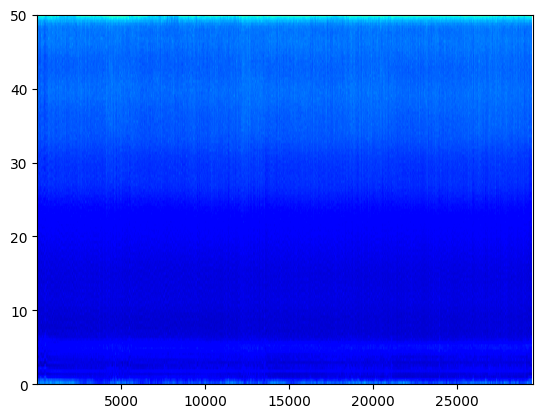

In [44]:
### Test creation of spectrogram
signal_spectrogram,freq,t  = create_spectrogram(np.array(filtered_signal).flatten(),
                                              nfft = 256,
                                              sample_frequency = 100, # set sample frequencey to be 100 as stated by the dataset
                                              noverlap = 32
                                              )
signal_spectrogram = np.array(signal_spectrogram)
print(signal_spectrogram.shape)
print('spectrogram avg value', np.mean(signal_spectrogram))

## 3. Pure CNN Model And Dataset

In [14]:
import torchvision
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import io
import torchvision
import torchvision.transforms as T

### 3.1 Dataset

In [15]:
def get_spectrogram_and_annotations(file_path, fs = 100):
  """Split up spectrogram into segments of around 60s in length"""
  signal_record = wfdb.rdrecord(file_path)
  signal = wfdb.rdrecord(file_path).p_signal
  signal_length = len(signal)
  filtered_signal = chebyshev_filter(signal_record)
  filtered_signal = np.array(filtered_signal).flatten()
  spectrogram,freqs,times = create_spectrogram(filtered_signal)
  spectrogram_length = spectrogram.shape[1]
  annotations = [[t] for t in wfdb.rdann(file_path, extension = "apn").symbol]
  num_annotations = len(annotations)

  spectrogram_segment_width = np.max(np.where(times < 60))
  spectrogram_gap = spectrogram_length // num_annotations
  spectrogram_end = (signal_length / fs) // num_annotations * num_annotations
  segment_spectrograms = []
  segment_times = []

  time_gap = round(signal_length / fs / num_annotations,1)
  time_window_start = 0
  time_window_end = time_gap
  cur_time = 0
  segment_pointer = 0

  start_index = -1
  end_index = -1

  while time_window_end <= times[-1]:
    start_index = np.min(np.where(times >= time_window_start))
    end_index = np.min(np.where(times >= time_window_end))
    segment_spectrograms.append(spectrogram[:,start_index:end_index])
    segment_times.append(times[start_index:end_index])
    time_window_start+=time_gap
    time_window_end+=time_gap
  # print('time window',time_window_start,time_window_end)
  if len(segment_spectrograms) < num_annotations:
    start_index =  np.min(np.where(times >= time_window_start))
    segment_spectrograms.append(spectrogram[:,start_index:-1])
  # print(segment_times[0])
  # print(segment_times[1])
  # print(segment_times[2])
  # print(segment_times[-3])
  # print(segment_times[-2])
  # print(segment_times[-1])
  correct_spectrogram_shape = segment_spectrograms[0].shape[1]
  print(f"number of spectrograms: {len(segment_spectrograms)}, number of annotations: {len(annotations)}")
  assert(len(segment_spectrograms) == len(annotations))
  # print('spectrogram shape',correct_spectrogram_shape)
  for i,spec in enumerate(segment_spectrograms):
    if abs(spec.shape[1] - correct_spectrogram_shape)>5:
      print('different spectrogram shape at index',i)
      print(i, spec.shape)
  correct_annotation_shape = len(annotations[0])
  # print('annotation shape',correct_annotation_shape)
  for i,ann in enumerate(annotations):
    if abs(len(ann) - correct_annotation_shape)>5:
      print('different annotation shape at index',i)
      print(i, len(ann))
    assert(len(ann) == correct_annotation_shape)
  return segment_spectrograms,annotations

In [16]:
# from https://www.kaggle.com/code/smjishanulislam/audio-mnist-with-pytorch
feature_transform_resize = T.Compose([
    T.ToPILImage(), # convert spectrogram to image
    T.Resize((100,100)),
    T.ToTensor() # convert to tensor
])
feature_transform = T.Compose([
    T.ToPILImage(), # convert spectrogram to image
    T.ToTensor() # convert to tensor
])

In [17]:
class SpectrogramDataset(Dataset):
  def __init__(self, file_paths = [], resize_spectrogram = True):
    super().__init__()
    self.spectrograms = []
    self.annotations = []
    self.resize_spectrogram = resize_spectrogram
    # add data from multiple files to this dataset
    for file_path in file_paths:
      segment_spectrograms, segment_annotations = get_spectrogram_and_annotations(file_path)
      self.spectrograms.extend(segment_spectrograms)
      self.annotations.extend(segment_annotations)
    self.spectrograms = [torch.from_numpy(spectrogram) for spectrogram in self.spectrograms]

  def __getitem__(self, idx):
    src = feature_transform_resize(self.spectrograms[idx]) * 10000 \
      if self.resize_spectrogram \
      else feature_transform(self.spectrograms[idx]) * 10000
    trg = self.annotations[idx]
    if trg[0] == "N":
      trg[0] = 0
    elif trg[0] == "A":
      trg[0] = 1
    # print('trg', trg)
    return src, trg
  def __len__(self):
    return len(self.spectrograms)

In [45]:
dataset_path = "apnea-ecg-database-1.0.0"
train_file_names = ["a01","a02","a03","a04","a05","b01","b02","b03","b04","b05","c01","c02","c03","c04","c05","x01","x02","x03","x04","x05","x06","x07"]

# create file path list for dataset
train_file_paths = [os.path.join(dataset_path, file_name) for file_name in train_file_names]
print("===> distribution of annotations across files")
for filename in train_file_paths:
  annotation = wfdb.rdann(filename, extension="apn")
  # Find out which heading contains the labels
  annotation.get_label_fields()
  # Count number of Apnea-tagged intervals
  annotation.symbol.count("A")
  # The readings are labelled normal (N) or atrial premature contraction (A)
  # There should be 470 As and 19 Ns for "a01"
  print(filename)
  print(np.unique(annotation.symbol, return_counts=True))

===> distribution of annotations across files
apnea-ecg-database-1.0.0/a01
(array(['A', 'N'], dtype='<U1'), array([470,  19]))
apnea-ecg-database-1.0.0/a02
(array(['A', 'N'], dtype='<U1'), array([420, 108]))
apnea-ecg-database-1.0.0/a03
(array(['A', 'N'], dtype='<U1'), array([246, 273]))
apnea-ecg-database-1.0.0/a04
(array(['A', 'N'], dtype='<U1'), array([453,  39]))
apnea-ecg-database-1.0.0/a05
(array(['A', 'N'], dtype='<U1'), array([276, 178]))
apnea-ecg-database-1.0.0/b01
(array(['A', 'N'], dtype='<U1'), array([ 19, 468]))
apnea-ecg-database-1.0.0/b02
(array(['A', 'N'], dtype='<U1'), array([ 93, 424]))
apnea-ecg-database-1.0.0/b03
(array(['A', 'N'], dtype='<U1'), array([ 73, 368]))
apnea-ecg-database-1.0.0/b04
(array(['A', 'N'], dtype='<U1'), array([ 10, 419]))
apnea-ecg-database-1.0.0/b05
(array(['A', 'N'], dtype='<U1'), array([ 57, 376]))
apnea-ecg-database-1.0.0/c01
(array(['N'], dtype='<U1'), array([484]))
apnea-ecg-database-1.0.0/c02
(array(['A', 'N'], dtype='<U1'), array([  1,

In [21]:
def collate_fn(data):
  return data
dataset_path = "apnea-ecg-database-1.0.0"

train_file_names = set(sorted([filename[:3]
                      for dirname, _, filenames in os.walk(dataset_path)
                      for filename in filenames
                      if (filename.startswith("a")
                      or filename.startswith("b")
                      or filename.startswith("c"))
                      and len(filename) <= 7
                      and "apn" in str(filename)]))
test_file_names = set(sorted([filename[:3]
                      for dirname, _, filenames in os.walk(dataset_path)
                      for filename in filenames
                      if filename.startswith("x")
                      and len(filename) <= 7
                      and "apn" in str(filename)]))
print('train file names')
print(train_file_names)
print(len(train_file_names))
print('test file names')
print(test_file_names)
print(len(test_file_names))

train file names
{'c10', 'a18', 'a02', 'b02', 'a07', 'c06', 'a15', 'c05', 'b05', 'c09', 'b03', 'a20', 'a10', 'b01', 'a08', 'a04', 'a03', 'a19', 'a11', 'a12', 'c03', 'c01', 'b04', 'a05', 'c02', 'a09', 'a17', 'a13', 'a14', 'c08', 'c07', 'a01', 'a16', 'c04', 'a06'}
35
test file names
{'x16', 'x03', 'x06', 'x21', 'x29', 'x04', 'x07', 'x08', 'x26', 'x22', 'x24', 'x30', 'x11', 'x18', 'x35', 'x34', 'x15', 'x17', 'x19', 'x05', 'x27', 'x33', 'x12', 'x32', 'x25', 'x13', 'x20', 'x01', 'x14', 'x28', 'x23', 'x31', 'x10', 'x02', 'x09'}
35


initialising train dataset for 35 files


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 431, number of annotations: 431
different spectrogram shape at index 430
430 (65, 38)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 489, number of annotations: 489
different spectrogram shape at index 488
488 (65, 34)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 528, number of annotations: 528
different spectrogram shape at index 527
527 (65, 31)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 517, number of annotations: 517
number of spectrograms: 511, number of annotations: 511


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 468, number of annotations: 468


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 510, number of annotations: 510
number of spectrograms: 466, number of annotations: 466


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 433, number of annotations: 433


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 468, number of annotations: 468
number of spectrograms: 441, number of annotations: 441
number of spectrograms: 510, number of annotations: 510
number of spectrograms: 517, number of annotations: 517
number of spectrograms: 487, number of annotations: 487
number of spectrograms: 501, number of annotations: 501


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 492, number of annotations: 492
different spectrogram shape at index 491
491 (65, 34)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 519, number of annotations: 519


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 502, number of annotations: 502
number of spectrograms: 466, number of annotations: 466
different spectrogram shape at index 465
465 (65, 30)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 577, number of annotations: 577


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 454, number of annotations: 454


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 484, number of annotations: 484


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 429, number of annotations: 429
different spectrogram shape at index 428
428 (65, 38)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 454, number of annotations: 454


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 502, number of annotations: 502


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 495, number of annotations: 495
different spectrogram shape at index 494
494 (65, 31)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 485, number of annotations: 485
different spectrogram shape at index 484
484 (65, 40)
number of spectrograms: 495, number of annotations: 495


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 509, number of annotations: 509


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 513, number of annotations: 513


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 429, number of annotations: 429
different spectrogram shape at index 428
428 (65, 40)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 489, number of annotations: 489
different spectrogram shape at index 488
488 (65, 34)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 482, number of annotations: 482


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 482, number of annotations: 482


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 510, number of annotations: 510
different spectrogram shape at index 509
509 (65, 30)


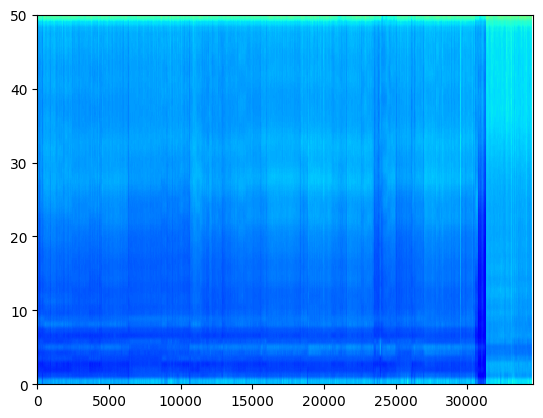

In [22]:
# list file names to be included in dataset
# train_file_names = ["a01","a02","a03","a04","a05","a06","a07","a08","a09","b01","b02","b03","b04","b05","c01","c02","c03","c04","c05","c06","c07","c08","c09"]
# create file path list for dataset
print(f'initialising train dataset for {len(train_file_names)} files')
train_file_paths = [os.path.join(dataset_path, file_name) for file_name in train_file_names]
train_dataset = SpectrogramDataset(train_file_paths, resize_spectrogram = True)

initialising test dataset for 35 files
number of spectrograms: 515, number of annotations: 515
different spectrogram shape at index 514
514 (65, 37)
number of spectrograms: 465, number of annotations: 465


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 450, number of annotations: 450
number of spectrograms: 510, number of annotations: 510
different spectrogram shape at index 509
509 (65, 26)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 470, number of annotations: 470


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 482, number of annotations: 482
different spectrogram shape at index 481
481 (65, 37)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 509, number of annotations: 509
number of spectrograms: 517, number of annotations: 517


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 520, number of annotations: 520
different spectrogram shape at index 519
519 (65, 38)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 482, number of annotations: 482


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 429, number of annotations: 429


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 511, number of annotations: 511


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 457, number of annotations: 457
different spectrogram shape at index 456
456 (65, 38)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 459, number of annotations: 459
different spectrogram shape at index 458
458 (65, 37)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 483, number of annotations: 483
number of spectrograms: 475, number of annotations: 475


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 498, number of annotations: 498
different spectrogram shape at index 497
497 (65, 29)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 400, number of annotations: 400
different spectrogram shape at index 399
399 (65, 31)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 487, number of annotations: 487
different spectrogram shape at index 486
486 (65, 28)
number of spectrograms: 505, number of annotations: 505
number of spectrograms: 498, number of annotations: 498
number of spectrograms: 473, number of annotations: 473


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 527, number of annotations: 527


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 538, number of annotations: 538
number of spectrograms: 510, number of annotations: 510


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 506, number of annotations: 506
different spectrogram shape at index 505
505 (65, 29)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 513, number of annotations: 513
number of spectrograms: 523, number of annotations: 523
different spectrogram shape at index 522
522 (65, 37)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 490, number of annotations: 490


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 495, number of annotations: 495


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 527, number of annotations: 527


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 557, number of annotations: 557


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 510, number of annotations: 510
different spectrogram shape at index 509
509 (65, 26)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 469, number of annotations: 469


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 508, number of annotations: 508
different spectrogram shape at index 507
507 (65, 37)


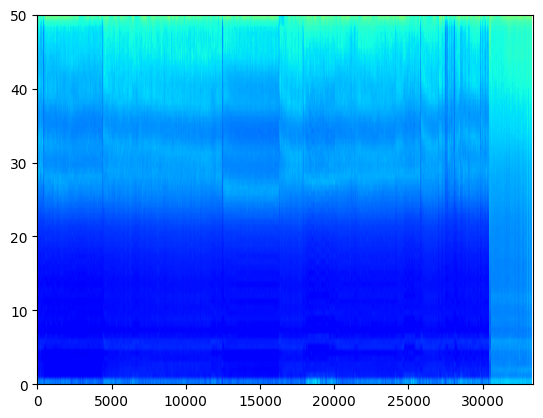

In [24]:
print(f'initialising test dataset for {len(test_file_names)} files')
test_file_paths = [os.path.join(dataset_path, file_name) for file_name in test_file_names]
test_dataset = SpectrogramDataset(test_file_paths, resize_spectrogram = True)

In [25]:
train_dl = DataLoader(
    train_dataset,
    batch_size = 8,
    shuffle = True,
    collate_fn = collate_fn,
    pin_memory = True
)
test_dl = DataLoader(
    test_dataset,
    batch_size = 8,
    shuffle = False,
    collate_fn = collate_fn,
    pin_memory = True
)

### 3.2 Pure CNN Model Defintion

In [26]:
!pip install einops

In [46]:
class CNN(nn.Module):
  def __init__(self,dropout = 0.1):
    super().__init__()
    self.cnn = nn.Sequential(
        # input size (batch_size, 1, 100, 100)
        nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size = 2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # size(batch_size, 128, 99, 99)
        nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # size(batch_size, 128, 98, 98)
        nn.MaxPool2d((2,2)),
        # size(batch_size, 128, 49, 49)
        nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # size(batch_size, 128, 48, 48)
        nn.MaxPool2d((2,2)),
        # # size(batch_size, 128, 24, 24)
        nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 2),
        # size(batch_size, 128, 23, 23)
        nn.BatchNorm2d(128),
        # nn.ReLU(),
    )
  def forward(self,src):
    out = self.cnn(src)
    return out

In [47]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
class PureCNN(nn.Module):
  def __init__(self,dropout=0.1):
    super().__init__()
    self.cnn = CNN(dropout)
    self.classifier = nn.Sequential(
        Rearrange('b c h w ->b (c h w)'),
        nn.Linear(67712,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,1),
        nn.Sigmoid()
    )
  def forward(self,src):
    src = self.cnn(src)
    return self.classifier(src)

### 3.3 Model Initialization

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
## default dropout set to 0.2
# model = PureCNN(dropout = 0.2)
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
# model.apply(init_weights)
# model.to(device)
# criterion = nn.BCELoss()
# ## deafult learning_rate set to 0.001
# learning_rate = 0.001
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
def get_model(pretrained_model_location = None):
    model = PureCNN(dropout = 0.1)
    try:
        state_dict = torch.load(pretrained_model_location)
        model.load_state_dict(state_dict)
        model.to(device)
        print('found pretrained model')
    except:
        model.apply(init_weights)
        model.to(device)
        print("no pretrained model found...")
    return model

In [74]:
def get_accuracy(outputs,target):
    correct = 0
    for output, target in zip(outputs, target):
        if output > 0.5:
          output = 1.0
        else:
          output = 0.0
        if output == target:
            correct += 1
    return correct / len(outputs)
def get_precision(outputs, target):
    correct = 0
    TP = 0
    FP = 0
    for output, target in zip(outputs, target):

      if output > 0.5:
        output = 1.0
      else:
        output = 0.0
      if output == 1 and target == 1:
        TP += 1
      elif output == 1 and target == 0:
        FP += 1
    if TP + FP == 0:
      return "NA"
    return TP/(TP+FP)
def get_recall(outputs,target):
    correct = 0
    TP = 0
    FN = 0
    for output, target in zip(outputs, target):
      if output > 0.5:
        output = 1.0
      else:
        output = 0.0
      if output == 1 and target == 1:
        TP += 1
      elif output == 0 and target == 1:
        FN += 1
    if TP + FN == 0:
      return "NA"
    return TP/(TP+FN)

In [75]:
def train_PureCNN(model, train_dl, print_interval = 5000):
  model.train()
  div = 100
  current_loss = 0
  current_accuracy = 0
  current_precision = 0
  current_recall = 0
  outputs_ls = []
  trgs_ls = []
  epoch_loss = 0
  epoch_output_ls = []
  epoch_trg_ls = []
  for i,data in enumerate(train_dl):
    optimizer.zero_grad()
    src = [_data[0] for _data in data]
    trg = [_data[1] for _data in data]
    src = torch.stack(src)
    b,c,h,w = src.shape
    src = src.float().to(device)
    trg = torch.tensor(trg)
    trg = trg.to(device)
    outputs = model(src)
    outputs = outputs.transpose(0,1)
    trg = trg.transpose(0,1)
    loss = criterion(outputs.float(),trg.float())
    current_loss += loss.item()
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
    outputs,trg = outputs.view(-1),trg.view(-1)
    epoch_output_ls.extend(outputs.tolist())
    epoch_trg_ls.extend(trg.tolist())
    outputs_ls.extend(outputs.tolist())
    trgs_ls.extend(trg.tolist())
    if i % print_interval == 0:
      current_accuracy = get_accuracy(outputs_ls, trgs_ls)
      precision = get_precision(outputs_ls, trgs_ls)
      recall = get_recall(outputs_ls, trgs_ls)
      current_precision = precision
      current_recall = recall
      print('iter',i)
      print('outputs')
      print(outputs.tolist())
      print('trg')
      print(trg.tolist())
      print(f'avg accuracy over {div} batches',current_accuracy)
      print(f'avg precision over {div} batches',current_precision)
      print(f'avg recall over {div} batches',current_recall)
      print(f'avg loss over {div} batches',current_loss/div)
      outputs_ls = []
      trgs_ls = []
      current_loss = 0
      current_accuracy = 0
      current_precision = 0
      current_recall = 0
  epoch_loss = epoch_loss/len(train_dl)
  epoch_accuracy = get_accuracy(epoch_output_ls,epoch_trg_ls)
  epoch_precision = get_precision(epoch_output_ls, epoch_trg_ls)
  epoch_recall = get_recall(epoch_output_ls, epoch_trg_ls)
  return {
      "epoch_loss":epoch_loss,
      "epoch_accuracy":epoch_accuracy,
      "epoch_precision":epoch_precision,
      "epoch_recall":epoch_recall
  }

In [76]:
def evaluate_PureCNN(model, test_dl, print_interval = 5000):
  div = 100
  current_loss = 0
  current_accuracy = 0
  current_precision = 0
  current_recall = 0
  outputs_ls = []
  trgs_ls = []
  epoch_loss = 0
  epoch_output_ls = []
  epoch_trg_ls = []
  model.eval()
  with torch.no_grad():
    for i,data in enumerate(test_dl):
      src = [_data[0] for _data in data]
      trg = [_data[1] for _data in data]
      src = torch.stack(src)
      b,c,h,w = src.shape
      # src = src.reshape((w, b, h))
      src = src.float().to(device)
      trg = torch.tensor(trg)
      trg = trg.to(device)
      # src = src.reshape(w,b,h)
      outputs = model(src)
      outputs = outputs.transpose(0,1)
      trg = trg.transpose(0,1)
      loss = criterion(outputs.float(),trg.float())
      current_loss += loss.item()
      epoch_loss += loss.item()
      outputs,trg = outputs.view(-1),trg.view(-1)
      epoch_output_ls.extend(outputs.tolist())
      epoch_trg_ls.extend(trg.tolist())
      outputs_ls.extend(outputs.tolist())
      trgs_ls.extend(trg.tolist())
      if i % print_interval == 0:
        print(outputs_ls, trgs_ls)
        current_accuracy += get_accuracy(outputs_ls, trgs_ls)
        precision = get_precision(outputs_ls, trgs_ls)
        recall = get_recall(outputs_ls, trgs_ls)
        current_precision = precision
        current_recall = recall
        print('iter',i)
        print('outputs')
        print(outputs.tolist())
        print('trg')
        print(trg.tolist())
        print(f'avg accuracy over {div} batches',current_accuracy)
        print(f'avg precision over {div} batches',current_precision)
        print(f'avg recall over {div} batches',current_recall)
        print(f'avg loss over {div} batches',current_loss/div)
        outputs_ls = []
        trgs_ls = []
        current_loss = 0
        current_accuracy = 0
        current_precision = 0
        current_recall = 0
  epoch_loss = epoch_loss/len(test_dl)
  epoch_accuracy = get_accuracy(epoch_output_ls,epoch_trg_ls)
  epoch_precision = get_precision(epoch_output_ls, epoch_trg_ls)
  epoch_recall = get_recall(epoch_output_ls, epoch_trg_ls)
  return {
      "epoch_loss":epoch_loss,
      "epoch_accuracy":epoch_accuracy,
      "epoch_precision":epoch_precision,
      "epoch_recall":epoch_recall
  }

In [92]:
def train_eval_loop(model_name, model, train_func, test_func, train_dl, test_dl, start_epoch = 0, num_epochs = 5, save = True, state_dict_name = "", print_interval = 5000):
  metrics = {
      "model_name":model_name,
      "num_epochs":num_epochs,
      "train":[],
      "test":[]
  }
  for epoch in range(start_epoch,start_epoch + num_epochs):
    print(f"===> epoch: {epoch}")
    print("===> train metrics")
    train_metrics = train_func(model, train_dl)
    print(train_metrics)
    print("===> evaluate")
    test_metrics = test_func(model, test_dl)
    print(test_metrics)
    metrics["train"].append(train_metrics)
    metrics["test"].append(test_metrics)
    if save:
        save_state_dict(model, f"{state_dict_name}_{epoch}")
  return metrics
def eval_loop(model_name, model, test_func, test_dl, print_interval = 5000):
  print("===> evaluate")
  test_metrics = test_func(model, test_dl, print_interval = print_interval)
  print(test_metrics)
  return metrics

In [95]:
#replace with desired pretrained model
pretrained_model_path = "PureCNN_v3_9" 
model = get_model(pretrained_model_path)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
model

found pretrained model


PureCNN(
  (cnn): CNN(
    (cnn): Sequential(
      (0): Conv2d(1, 128, kernel_size=(2, 2), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
      (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (classifier): Sequential(
    (0): Rearrange('b c h w ->b (c h w)')
    (1)

### 3.4 Eval Loop

In [96]:
from enum import Enum
class Models(Enum):
  PureCNN = "PureCNN"

In [97]:
eval_loop(Models.PureCNN.value, model, evaluate_PureCNN, test_dl)

===> evaluate
[0.7468397617340088, 0.9034594297409058, 0.0011072482448071241, 0.6604785323143005, 0.9721853137016296, 0.18582327663898468, 0.1702423393726349, 0.0020968494936823845] [0, 0, 0, 0, 0, 0, 0, 0]
iter 0
outputs
[0.7468397617340088, 0.9034594297409058, 0.0011072482448071241, 0.6604785323143005, 0.9721853137016296, 0.18582327663898468, 0.1702423393726349, 0.0020968494936823845]
trg
[0, 0, 0, 0, 0, 0, 0, 0]
avg accuracy over 100 batches 0.5
avg precision over 100 batches 0.0
avg recall over 100 batches NA
avg loss over 100 batches 0.010961675643920898
{'epoch_loss': 0.9762255236580591, 'epoch_accuracy': 0.6523627519110493, 'epoch_precision': 0.5371149409689239, 'epoch_recall': 0.6042748091603053}


[]

In [98]:
metrics = []

In [99]:
metrics.append(train_eval_loop(
    Models.PureCNN.value,
    model,
    train_PureCNN,
    evaluate_PureCNN,
    train_dl,test_dl,
    start_epoch = 0,
    num_epochs = 10,
    save = False,
    print_interval = 5000
))

===> epoch: 0
===> train metrics
iter 0
outputs
[0.4540291428565979, 0.8717496395111084, 0.4540291428565979, 0.4540291428565979, 0.35583680868148804, 0.9277722835540771, 4.411609916132875e-05, 2.795092939322785e-07]
trg
[1, 1, 1, 1, 0, 1, 0, 0]
avg accuracy over 100 batches 0.625
avg precision over 100 batches 1.0
avg recall over 100 batches 0.4
avg loss over 100 batches 0.0037760639190673826
{'epoch_loss': 0.25957978529292236, 'epoch_accuracy': 0.8652977412731007, 'epoch_precision': 0.9311120196238757, 'epoch_recall': 0.6992631255756832}
===> evaluate
[0.00015115461428649724, 0.0053330096416175365, 0.002577578416094184, 0.5490796566009521, 0.2687382102012634, 0.13751636445522308, 0.0027103901375085115, 0.0030840232502669096] [0, 0, 0, 0, 0, 0, 0, 0]
iter 0
outputs
[0.00015115461428649724, 0.0053330096416175365, 0.002577578416094184, 0.5490796566009521, 0.2687382102012634, 0.13751636445522308, 0.0027103901375085115, 0.0030840232502669096]
trg
[0, 0, 0, 0, 0, 0, 0, 0]
avg accuracy over 

### 3.6 View Metrics Obtained from Training

In [ ]:
flattened_train_metrics = []
flattened_test_metrics = []
for metric_dict in metrics:
  flattened_train_metrics.extend(metric_dict["train"])
  flattened_test_metrics.extend(metric_dict["test"])
print(flattened_test_metrics)

In [ ]:
loss_plot = [metric["epoch_loss"] for metric in flattened_test_metrics]
precision_plot = [metric["epoch_precision"] for metric in flattened_test_metrics]
accuracy_plot = [metric["epoch_accuracy"] for metric in flattened_test_metrics]
recall_plot = [metric["epoch_recall"] for metric in flattened_test_metrics]
print('loss per epoch',loss_plot)
print('precision per epoch',precision_plot)
print('accuracy per epoch', accuracy_plot)
print('recall per epoch', recall_plot)

In [ ]:
X = np.arange(1,11)
print(X.shape)
print(np.array(precision_plot).shape)
plt.figure(figsize=(10,10))

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)

# For Sine Function
axis[0, 0].plot(X, np.array(precision_plot))
axis[0, 0].set_title("Precision / epoch")

# For Cosine Function
axis[0, 1].plot(X, np.array(recall_plot))
axis[0, 1].set_title("Recall / epoch")

# For Tangent Function
axis[1, 0].plot(X, np.array(accuracy_plot))
axis[1, 0].set_title("Accuracy / epoch")

# For Tanh Function
axis[1, 1].plot(X, np.array(loss_plot))
axis[1, 1].set_title("Loss / epoch")
plt.tight_layout()

plt.show()

### Plotting

In [100]:
loss_plot = [metric["epoch_loss"] for metric in flattened_test_metrics]
precision_plot = [metric["epoch_precision"] for metric in flattened_test_metrics]
accuracy_plot = [metric["epoch_accuracy"] for metric in flattened_test_metrics]
recall_plot = [metric["epoch_recall"] for metric in flattened_test_metrics]

NameError: name 'flattened_test_metrics' is not defined

In [ ]:
X = np.arange(1,11)
print(X.shape)
print(np.array(precision_plot).shape)
plt.figure(figsize=(10,10))

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)

# For Sine Function
axis[0, 0].plot(X, np.array(precision_plot))
axis[0, 0].set_title("Precision / epoch")

# For Cosine Function
axis[0, 1].plot(X, np.array(recall_plot))
axis[0, 1].set_title("Recall / epoch")

# For Tangent Function
axis[1, 0].plot(X, np.array(accuracy_plot))
axis[1, 0].set_title("Accuracy / epoch")

# For Tanh Function
axis[1, 1].plot(X, np.array(loss_plot))
axis[1, 1].set_title("Loss / epoch")
plt.tight_layout()

plt.show()